In [40]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name = "Gemma2-9b-It")
llm.invoke("Hey there").content

'Hey there! 👋 How can I help you today?\n'

In [41]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [42]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [43]:
workflow = StateGraph(MessagesState)
workflow.add_node('chatbot', call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge('chatbot', END)
app = workflow.compile()

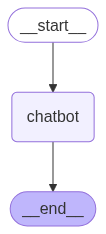

In [44]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [45]:
input = {"messages": ["Hey, my name is Jimmy"]}
app.invoke(input)

{'messages': [HumanMessage(content='Hey, my name is Jimmy', additional_kwargs={}, response_metadata={}, id='c5d2219f-e285-467e-96e5-328c129c2554'),
  AIMessage(content="Hi Jimmy, it's nice to meet you! 👋 \n\nWhat can I do for you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 0.0018867, 'queue_time': 0.16112472800000002, 'total_time': 0.049159427}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--7d7003fb-109f-410d-a19f-fa55570d3d25-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}

In [46]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"Ouput from {key} Node")
        print("_____________")
        print(value)
        print("\n")

Ouput from chatbot Node
_____________
{'messages': [AIMessage(content="Hi Jimmy! It's nice to meet you. 👋 \n\nWhat can I do for you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 0.001952459, 'queue_time': 0.158064895, 'total_time': 0.049225186}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--1220dd0d-092b-4777-8f83-330b0961a59e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}




In [47]:
@tool
def search(query: str):
    """This is a custom tool to check weather"""
    if 'sf' in query.lower() or 'san francisco' in query.lower():
        return "It is 20 degrees and foggy."
    return "It is 35 degrees and sunny."

In [48]:
search.invoke("What is the temperature in sf?")

'It is 20 degrees and foggy.'

In [49]:
search.invoke("What is the temperature in Qatar?")

'It is 35 degrees and sunny.'

In [50]:
tools = [search]

In [51]:
tool_node = ToolNode(tools)

In [52]:
llm_with_tool = llm.bind_tools(tools)

In [53]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [54]:
response=call_model({"messages": ["hi how are you?"]})

In [55]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dyd8r7vbg', 'function': {'arguments': '{"query":"hi how are you?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 943, 'total_tokens': 1026, 'completion_time': 0.150909091, 'prompt_time': 0.032836536, 'queue_time': 0.159464651, 'total_time': 0.183745627}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--67ec7c76-91c0-49fe-978b-b777881ed62d-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you?'}, 'id': 'dyd8r7vbg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 83, 'total_tokens': 1026})]}

In [56]:
response = call_model({"messages": ["what is the weather in kenya?"]})

In [57]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'm2drhwc4h', 'function': {'arguments': '{"query":"weather in kenya"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 946, 'total_tokens': 1029, 'completion_time': 0.150909091, 'prompt_time': 0.042128265, 'queue_time': 0.338094735, 'total_time': 0.193037356}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--44895f67-a6cc-47d4-8154-fc8a183366aa-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in kenya'}, 'id': 'm2drhwc4h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 83, 'total_tokens': 1029})]}

In [58]:
messages = response['messages']
last_message = messages[-1]
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in kenya'},
  'id': 'm2drhwc4h',
  'type': 'tool_call'}]

In [59]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [60]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

In [61]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [62]:
app.invoke({"messages": ["Hey there how are you ?"]})

{'messages': [HumanMessage(content='Hey there how are you ?', additional_kwargs={}, response_metadata={}, id='583f39b6-331f-4bc6-a620-0e71af410c2c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'p2jg5kkp2', 'function': {'arguments': '{"query":"How are you?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 944, 'total_tokens': 1024, 'completion_time': 0.145454545, 'prompt_time': 0.040749636, 'queue_time': 0.352306714, 'total_time': 0.186204181}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dbbdb1e9-2545-48d7-b542-b66a7e3408f0-0', tool_calls=[{'name': 'search', 'args': {'query': 'How are you?'}, 'id': 'p2jg5kkp2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 944, 'output_tokens': 80, 'total_tokens': 1024}),
  ToolMessage(content='It is 35 degrees and sunny.', name='search', id='6d152ae4-b8e8-4908-84b4-7d

In [63]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='1b25a57a-9b3c-4ef3-a5df-44eef91b587c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'd92wdsbzj', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 944, 'total_tokens': 1026, 'completion_time': 0.149090909, 'prompt_time': 0.040576956, 'queue_time': 0.161204724, 'total_time': 0.189667865}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bd2e3c4a-9980-4045-969c-b9c9a3ce7256-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'd92wdsbzj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 944, 'output_tokens': 82, 'total_tokens': 1026}),
  ToolMessage(content='It is 20 degrees and foggy.', name='search', id='13cc3335-6623-42d1-ac2

In [64]:
workflow.add_edge('tools', 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [65]:
app = workflow.compile()

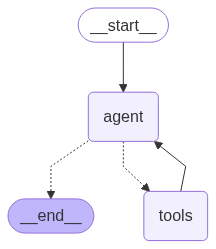

In [66]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [67]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'k41m2wshc', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 944, 'total_tokens': 1024, 'completion_time': 0.145454545, 'prompt_time': 0.040587766, 'queue_time': 0.160459281, 'total_time': 0.186042311}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--347bdf08-4d8b-4a84-b8ba-d19a10fc5ce4-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'k41m2wshc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 944, 'output_tokens': 80, 'total_tokens': 1024})]}


here is output from tools
_______
{'messages': [ToolMessage(content='It is 20 degrees and foggy.', name='search', id='d700d222-da80-4996-9166-a9160ec0f246', tool_call_id='k41m2wshc')]}


here is ou

In [68]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [69]:
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [70]:
app2 = workflow3.compile(checkpointer = memory)

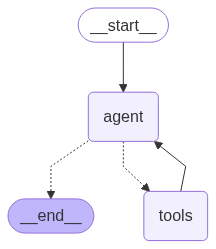

In [71]:
from IPython.display import Image, display
try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [72]:
config = {"configurable": {"thread_id": "1"}}

In [73]:
events = app2.stream(
    {"messages": ["Hi there! My name is Jimmy"]}, config, stream_mode="values"
)

In [74]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Jimmy
================================== Ai Message ==================================
Tool Calls:
  search (qjp4wc28d)
 Call ID: qjp4wc28d
  Args:
    query: Hi there! My name is Jimmy
================================= Tool Message =================================
Name: search

It is 35 degrees and sunny.
================================== Ai Message ==================================
Tool Calls:
  search (db9pmyn95)
 Call ID: db9pmyn95
  Args:
    query: What is the weather like?
================================= Tool Message =================================
Name: search

It is 35 degrees and sunny.
================================== Ai Message ==================================

It is 35 degrees and sunny.


In [75]:
events = app2.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [76]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Your name is Jimmy.


In [77]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-02T15:31:08.298540+00:00',
 'id': '1f057599-3455-6635-8008-e9c6ed1b0312',
 'channel_versions': {'__start__': '00000000000000000000000000000009.0.6527839195934059',
  'messages': '00000000000000000000000000000010.0.9531956276901375',
  'branch:to:agent': '00000000000000000000000000000010.0.9531956276901375',
  'branch:to:tools': '00000000000000000000000000000006.0.5318776421587786'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000008.0.9693365966094609'},
  'agent': {'branch:to:agent': '00000000000000000000000000000009.0.6527839195934059'},
  'tools': {'branch:to:tools': '00000000000000000000000000000005.0.425589163224251'}},
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Jimmy', additional_kwargs={}, response_metadata={}, id='eb149c1d-b58b-404e-9a6d-a96652e26c9a'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qjp4wc28d', 'function': {'arguments': '{"query":"Hi the